### QC performance of the trained de-speckling conditional diffusion model on test DOQ images

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.distributions.gamma import Gamma
import torch.utils
import torch.utils.data
from torchvision import transforms
from datasets import load_dataset
from diffusers import DDPMScheduler, UNet2DModel

from sar_denoise.DDPMSpecklePipeline import DDPMSpecklePipeline
from sar_denoise.dataset_transforms import make_transform_images 

In [3]:
unet = UNet2DModel.from_pretrained("/data/capstone_training/speckle_1/unet")
# use torch.compile on this

In [3]:
# count unet parameters
num_params = sum(p.numel() for p in unet.parameters())
num_params

28445505

In [4]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="linear")

In [5]:
# TODO can just load pipeline instead of loading unet?
pipeline = DDPMSpecklePipeline(
    unet=unet,
    scheduler=noise_scheduler,
).to("cuda")

device = pipeline.device

In [6]:


full_dataset = load_dataset("ReginaFoley/doq_data_large_64")
full_dataset.set_transform(make_transform_images(64))

num_images = 16
image_indices = (np.r_[:16] * 1777 + 494).astype(int).tolist()
dataset = torch.utils.data.Subset(full_dataset["train"], image_indices)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)

In [7]:
def normalize_image(image):
    return (image - image.min()) / (image.max() - image.min())

def plottable_image(image):
    return (normalize_image(image) * 255).float().round().cpu().squeeze((0, 1)).numpy().astype(np.uint8)

def plot_image_batch(images):
   # TODO normalize each image in the batch individually
   images_np = plottable_image(images)

   fig, axs = plt.subplots(4, 4, figsize=(10, 10))
   for i, ax in enumerate(axs.flat):
       ax.imshow(images_np[i], cmap="gray")
       ax.axis("off")

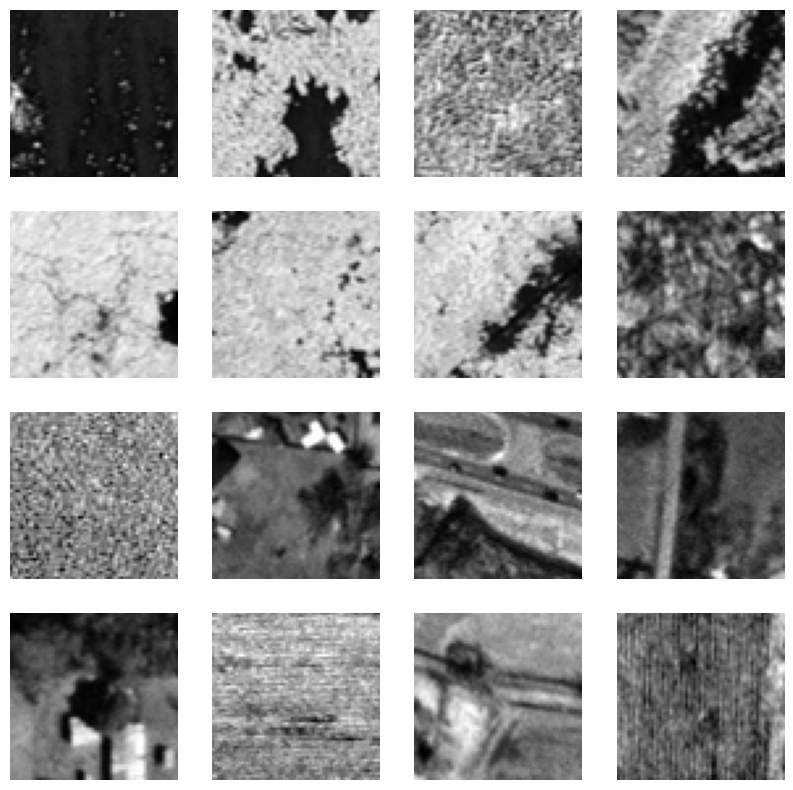

In [8]:
val_batch = next(iter(dataloader))
val_images = val_batch["input"].to(device)

plot_image_batch(val_images)

plt.savefig('/data/images/doq_denoise1.png', dpi=300)

In [9]:
gamma_param = torch.tensor(4., device=device)
gamma_dist = Gamma(gamma_param, gamma_param)

# Sample speckle noise
speckle = gamma_dist.sample(val_images.shape).to(device)
#speckle_images = normalize_image(val_images * speckle)
speckle_images = transforms.functional.normalize(
    val_images * speckle,
    mean=torch.tensor(0.5, device=device),
    std=torch.tensor(0.5, device=device),
)
generator = torch.Generator(device=pipeline.device).manual_seed(0)
# run pipeline in inference (sample random noise and denoise)
denoised_images = pipeline(
    generator=generator,
    conditional_images=speckle_images,
    num_inference_steps=1000,
    output_type="pil",
).images

  0%|          | 0/1000 [00:00<?, ?it/s]

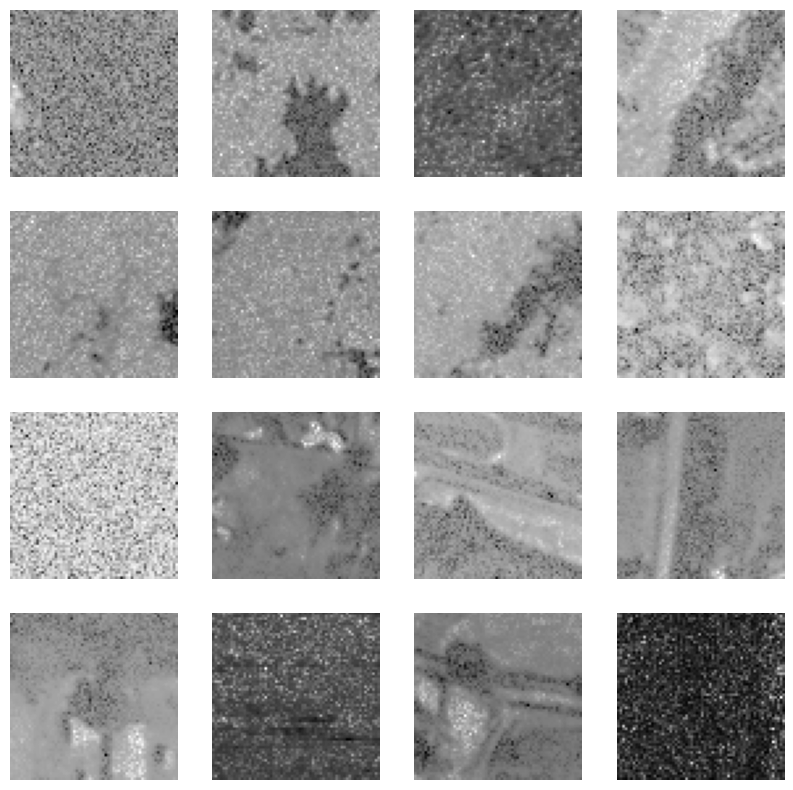

In [10]:
plot_image_batch(speckle_images)

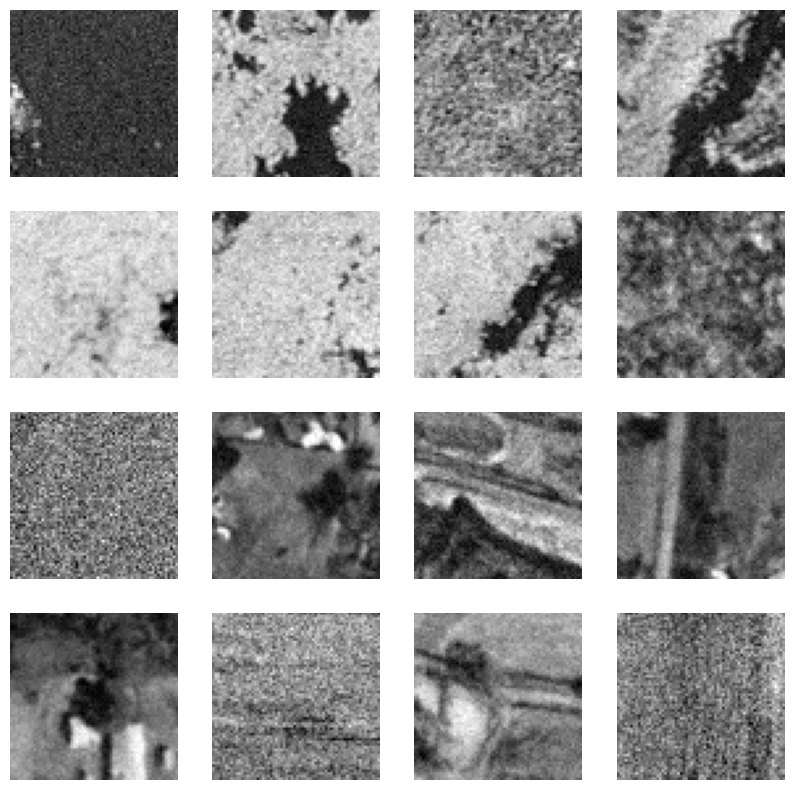

In [11]:
# plot 4x4 grid of denoised images
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    ax.imshow(denoised_images[i], cmap="gray")
    ax.axis("off")

### Saving images for the report, image display is off:


In [20]:
for i in range(len(denoised_images)):
    plt.ioff()
    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    axs[0].set_title("clean")
    axs[1].set_title("speckle")
    axs[2].set_title("denoise")
    axs[0].imshow(plottable_image(val_images[i]), cmap="gray")
    axs[0].axis("off")
    axs[1].imshow(plottable_image(speckle_images[i]), cmap="gray")
    axs[1].axis("off")
    axs[2].imshow(denoised_images[i], cmap="gray")
    axs[2].axis("off")
    # plt.savefig('/data/images/doq_despeckling' + str(i) +  '.png', dpi=300)
    plt.tight_layout()
    plt.ion()

### Displaying images for denoise QC:

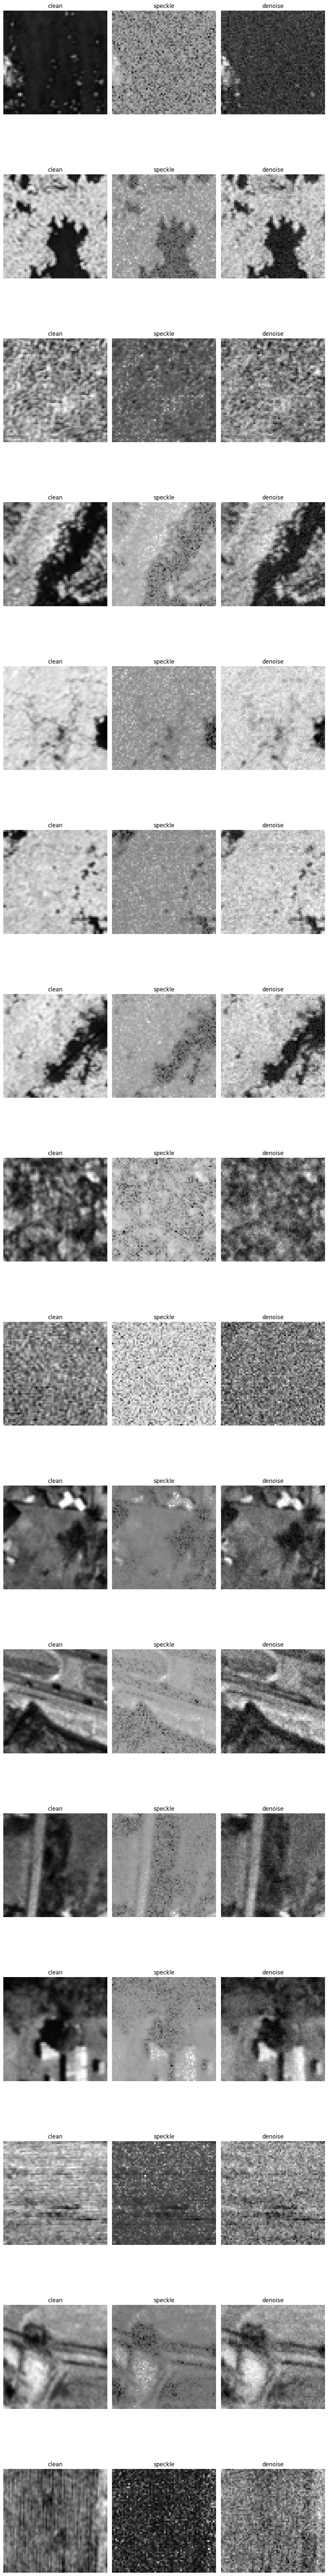

In [12]:

fig, axs = plt.subplots(len(denoised_images), 3, figsize=(10, 5*len(denoised_images)))
for i in range(len(denoised_images)):
    axs[i][0].set_title("clean")
    axs[i][1].set_title("speckle")
    axs[i][2].set_title("denoise")
    axs[i][0].imshow(plottable_image(val_images[i]), cmap="gray")
    axs[i][0].axis("off")
    axs[i][1].imshow(plottable_image(speckle_images[i]), cmap="gray")
    axs[i][1].axis("off")
    axs[i][2].imshow(denoised_images[i], cmap="gray")
    axs[i][2].axis("off")
plt.tight_layout()